
This is a Jupyter Notebook accompanying a Lightning talk presented during JuliaCon2021


# Simulating a public transportation system with OpenStreetMapX.jl
### Przemysław Szufel


### Co-authors: Nykyta Polituchyi, Kinga Siuta, Paweł Prałat

*The research is financed by a NSERC, Canada, 
Alliance COVID-19" grant titled: "COVID-19: Agent-based framework for modelling pandemics in urban environment"
and is done at Ryerson University, Canada with cooperation from Security Compass.*


Any transportation network can be represented as a complex directed graph where vertices are spread an Euclidean space. The library provides a bridging functionality between real world spatial data available in the OpenStreetMap project and LightGraphs.jl and makes it possible to run real-life-sized experiment on transportation networks along with various visualizations.





This notebook can be downloaded in Jupyter ipynb format [here](https://szufel-public.s3.us-east-2.amazonaws.com/SimulatingPublicTransportationSystemOSMX.ipynb) (right-click to download).
The source code uses a `central_torontoF.osm` file which you can also download [here](https://szufel-public.s3.us-east-2.amazonaws.com/central_torontoF.osm).

Firstly, let us start by installing the required Julia and Python packages. (If the packages are required uncomment the code below)

In [1]:
#using Pkg
#pkg"add OpenStreetMapX, OpenStreetMapXPlot, Parameters, LightGraphs, PyCall, Conda, Colors, CSV, DataFrames, LightGraphs, DataStructures"
#using Conda
#Conda.runconda(`install folium -c conda-forge --yes`)

Now we are ready to load all required packages

In [2]:
using Random, Parameters, OpenStreetMapX, LightGraphs, PyCall, CSV, DataFrames, SparseArrays, LightGraphs, DataStructures
using Plots
ENV["GKSwstype"]="nul"  # this parameter significantly speeds up generation of GR-based plots
gr()
using OpenStreetMapXPlot
const flm = pyimport("folium");

In [3]:
pwd()  # use this to to check in which folder you are, the folder should contain the torontoF.osm file

"C:\\AAABIBLIOTEKA\\JuliaCon2021\\demo\\OpenStreetMapX_Tutorial\\JuliaCon2021"

We start by loading the file. Note that we trim the map file to have a fully connected road network.

> The file was downloaded from the [OpenStreetMap](https://www.openstreetmap.org/) project web page. The steps included: (1) Select some area on map; (2) Click the "Export" button at the top of the page; (3) Click "Manually select a different area" to select the central Toronto area; (4) Press the "Export" button on the left (note that sometimes the Export link does not work - in this case click one of the Overpass API link below the Export button).



In [92]:
m = get_map_data("central_torontoF.osm", use_cache=false, trim_to_connected_graph=true );
typeof(m)

MapData

In [93]:
?MapData

search: MapData get_map_data



The `MapData` represents all data that have been processed from OpenStreetMap osm file This is the main data structure used fot map data analytics.

**Fields**

  * `bounds` :  bounds of the area map (stored as a OpenStreetMapX.Bounds object)
  * `nodes` :  dictionary of nodes representing all the objects on the map (with coordinates in East, North, Up system)
  * `roadways` :  unique roads stored as a OpenStreetMapX.Way objects
  * `intersections` : roads intersections
  * `g` : `LightGraphs` directed graph representing a road network
  * `v` : vertices in the road network (node id .=> graph vertex)
  * `n` : vector of OpenStreetMap node ids for each corresponding graph vertex
  * `e` : vector of edges in the graph represented as a tuple (source,destination)
  * `w` : sparse matrix of edge weights, indexed by graph id
  * `class` : road class of each edge

---

Internal constructor of `MapData` object


The central element of the `MapData` object is a `LightGraphs`' representation of the road network

In [94]:
m.g

{179, 354} directed simple Int64 graph

The LightGraph graph is represented by nodes, each node id can be directly mapped to OpenStreetMap. 

In [95]:
m.n

179-element Vector{Int64}:
            29687315
           966538876
            29688406
            29688407
            29605017
            34600564
           393551267
            29603222
           443723703
           145488869
          1894129943
          2457608913
            29604906
                   ⋮
            29687510
 8307076682751450643
           765380100
           780794971
            29687649
          1815416529
           390998530
  224925702395554531
           304904382
          3843340562
            34598911
            53542723

Furhther, those nodes can be presented as geographic coordinates

In [96]:
m.nodes

Dict{Int64, ENU} with 744 entries:
  6532307455 => ENU(-341.765, 565.58, -0.0342666)
  6593471028 => ENU(255.988, 177.729, -0.00760988)
  3700157943 => ENU(-269.491, -584.309, -0.0325004)
  29688214   => ENU(547.111, 352.804, -0.0332043)
  4204756690 => ENU(-126.107, -484.707, -0.0196979)
  394497217  => ENU(401.392, 500.575, -0.0322913)
  393546107  => ENU(-258.402, 113.932, -0.00624562)
  32547299   => ENU(-220.929, 125.097, -0.00504936)
  393551222  => ENU(-13.0844, 661.744, -0.0344082)
  6294585469 => ENU(512.134, -209.903, -0.0239888)
  1895652027 => ENU(-508.215, 721.56, -0.061109)
  6294585463 => ENU(456.838, -228.439, -0.0204333)
  6509238509 => ENU(-220.461, 123.631, -0.00500454)
  393552046  => ENU(-380.81, 547.75, -0.0349156)
  6509238507 => ENU(-221.429, 126.597, -0.00509632)
  469107079  => ENU(-155.844, -409.655, -0.0150819)
  7137874035 => ENU(-243.219, -88.4244, -0.00524407)
  6509260328 => ENU(-267.934, 19.0377, -0.0056472)
  29687649   => ENU(-233.151, -122.523, -0.00

In [97]:
ttc_data = """
lat	lon	name
43.656136534	-79.380729654	Dundas
43.652346514	-79.379326503	Queen
43.649120879	-79.378045133	King
43.645722666	-79.380462258	Union
43.647645649	-79.385130483	St Andrew
43.650874106	-79.386617316	Osgoode
43.654611638	-79.388295977	St Patrick
""";# Sample file with real locations

In [98]:
ttc = CSV.File(IOBuffer(ttc_data)) |> DataFrame


,lat,lon,name
,Float64,Float64,String
1,43.6561,-79.3807,Dundas
2,43.6523,-79.3793,Queen
3,43.6491,-79.378,King
4,43.6457,-79.3805,Union
5,43.6476,-79.3851,St Andrew
6,43.6509,-79.3866,Osgoode
7,43.6546,-79.3883,St Patrick


In [99]:
m = get_map_data("central_torontoF.osm", use_cache=false, trim_to_connected_graph=true );

function add_graph_edge!(m::MapData, va::Int, vb::Int;symmetric=false)
    LightGraphs.add_edge!(m.g, va, vb)
    push!(m.e,(m.n[va], m.n[vb]) )
    symmetric && add_graph_edge!(m, vb, va; symmetric=false)
end

wI, wJ, wV = findnz(m.w) 
agent_speed = 3_000/60 # meters in minute (that  is 3km/h)
wV = wV ./ agent_speed # all distances in minutes instead of meters
points = [ENU(LLA(ttc.lat[t], ttc.lon[t]), m.bounds) for t in 1:nrow(ttc)]
nodecs = nearest_node.(Ref(m), points)

for t in 1:nrow(ttc)
    LightGraphs.add_vertex!(m.g)
    vx = nv(m.g)        
    push!(m.n, -vx) # add vertex to MapData - negative indices are used for special purposes
                   #for simplicity we assume no identifier clash
    m.nodes[-vx] = points[t]
    m.v[-vx] = vx
    vc = m.v[nodecs[t]]
    
    add_graph_edge!(m, vc, vx; symmetric=true)
    
    append!(wI, [vx, vc])
    append!(wJ, [vc, vx])
    append!(wV, [3.0, 3.0]) # getting in or out of TTC takes 3 minutes    
    if t>1  #build the TTC line in graph 
        add_graph_edge!(m, vx-1, vx; symmetric=false)
        append!(wI, vx-1)
        append!(wJ, vx)
        append!(wV, 2.0) # TTC travels 2 minutes between stops 
                                # this is a simplificatio of course real data
                                # could be used
        
    end
    
end
# now we construct the updated distance matrix:
m.w = sparse(wI,wJ,wV)
@assert size(m.w,1)==size(m.w,2)
@assert size(m.w,1)==nv(m.g)



Now we will plot the TTC line

In [100]:
fm = flm.Map()


ttc_locs = [LLA(m.nodes[m.n[end-nrow(ttc)+t]],m.bounds) for t in 1:nrow(ttc)]

flm.PolyLine(        
        [(loc.lat, loc.lon) for loc in ttc_locs ],
        color="red",
        opacity=0.2,
    weight=25
    
    ).add_to(fm)
for loc in ttc_locs
    flm.Circle((loc.lat, loc.lon), color="",
        fill_color="red", fill_opacity=0.35).add_to(fm)
end

MAP_BOUNDS = [(m.bounds.min_y,m.bounds.min_x),(m.bounds.max_y,m.bounds.max_x)]
flm.Rectangle(MAP_BOUNDS, color="black",weight=6).add_to(fm)
fm.fit_bounds(MAP_BOUNDS)
fm


PyObject <folium.folium.Map object at 0x0000000068D116A0>

In [101]:
Random.seed!(0)
#node_ids = sort!(collect(keys(m.nodes))) 
routes = Vector{Vector{Int}}()
for k in 1:10
    a,b = rand(1:(nv(m.g)-nrow(ttc)), 2)
    route, rtime = OpenStreetMapX.find_route(m,m.n[a],m.n[b],m.w)
    
    push!(routes, route)
end                                   

In [102]:
colrs = distinguishable_colors(100, [RGB(1,0.6,0.5)])

for k=10:10
    locs = [LLA(m.nodes[n],m.bounds) for n in routes[k]]
    mycolor = "#$(hex(colrs[k]))"
    info = "The route of Pedestrian $k\n<BR>"*
        "Length: $(length(routes[k])) nodes\n<br>" *
        "From: $(routes[k][1]) $(round.((locs[1].lat, locs[1].lon),digits=4))\n<br>" *
        "To: $(routes[k][end]) $(round.((locs[end].lat, locs[end].lon),digits=4))"
    flm.Marker(
              location=(locs[1].lat,locs[1].lon),
              icon=flm.Icon(color="black", icon="home")
           ).add_to(fm)
    
    flm.PolyLine(        
        [(loc.lat, loc.lon) for loc in locs ],
        popup=info,
        tooltip=info,
        color=mycolor
    ).add_to(fm)
    flm.Marker(
        location=(locs[end].lat,locs[end].lon),
              icon=flm.Icon(color="black", icon="flag")
           ).add_to(fm)
    
end
fm

PyObject <folium.folium.Map object at 0x0000000068D116A0>

Let now us try to built a simple simulation model for agents travelling in the city.

We start by a data structure defining location of an agent traversing the graph:

In [103]:
struct OSMXPos
    node1::Int # starting node
    node2::Int # target node (if it is equal to node1 the agent 
               # makes decision on the next step)
    trav::Float64 #travelled %
end
# helper constructors for representation of movement
OSMXPos(node1::Int, node2::Int) = OSMXPos(node1, node2, 0.0) #agent decided to head to node 2
OSMXPos(node::Int) = OSMXPos(node, node) # agent arrived to node
function OSMXPos(pos::OSMXPos, delta::Float64)
    trav = pos.trav + delta
    trav >= 1.0 && return OSMXPos(pos.node2)
    trav <= 0.0 && return OSMXPos(pos.node1)
    return OSMXPos(pos.node1, pos.node2, trav)
end

OSMXPos

We move to a definition of an `Agent`

In [104]:
@with_kw mutable struct Agent
    id::Int
    pos::OSMXPos
    #travel plan
    path::Vector{Int} = Int[]
    commuting::Bool = false
end
Agent(id, pos)=Agent(id=id, pos=pos)

@with_kw mutable struct Wagon
    id::Int
    pos::OSMXPos
    #travel plan
    path::Vector{Int} = Int[]
    passengers::Vector{Agent} = Agent[]
    color::Symbol = :yellow
end
Wagon(pos)=Wagon(pos=pos)

Wagon

Once the agent is defined let us define the enviroment where they can move around.

In [105]:
const EventTime = Tuple{Float64,Float64}
struct Simulation
    agents::Vector{Agent} 
    wagons::Vector{Wagon}
    m::MapData
    events::PriorityQueue{Union{Agent,Wagon}, EventTime}
    ttc::DataFrame
    ttc_line::Vector{Int}
    station_q::Vector{Vector{Agent}}
end

# constructor
# simulation initializer
function Simulation(m::MapData, ttc::DataFrame, ttc_line = (nv(m.g)-nrow(ttc)+1):nv(m.g); N=150)    
    events = PriorityQueue{Union{Agent,Wagon}, EventTime}()
    vv = nv(m.g)-nrow(ttc) # number of vertices for agent locations
    agents = Agent.(1:N, Ref(OSMXPos(1, 2)))
    wagons = [Wagon(id=n,pos=OSMXPos(n,n+1 <= nrow(ttc) ? n+1 : 1),path=ttc_line) for n in 1:nrow(ttc)]    
    enqueue!.(Ref(events), wagons, Ref(EventTime((0.5,0.0))))
    enqueue!.(Ref(events), agents, Ref(EventTime((0.0,0.0))))
        
    for agent in agents
        a = rand(1:(nv(m.g)-nrow(ttc)))
        b = a
        while (a==b)
            b = rand(1:(nv(m.g)-nrow(ttc)))
        end
        route, rtime = OpenStreetMapX.find_route(m,m.n[a],m.n[b],m.w)
        agent.path = [m.v[r]  for r in route] 
    end
    Simulation(agents, wagons, m, events, ttc, ttc_line, [Vector{Agent}[] for _ in 1:nrow(ttc)])
end

Simulation

In [106]:
Random.seed!(0)
s = Simulation(m, ttc; N=50);

In [107]:
s.agents[2]

Agent
  id: Int64 2
  pos: OSMXPos
  path: Array{Int64}((13,)) [74, 172, 104, 16, 157, 158, 117, 35, 38, 37, 60, 123, 124]
  commuting: Bool false


Now we define the plotting function:

In [108]:
# helper functions for location processing
function get_ENU(node::Int, model::Simulation)
    model.m.nodes[m.n[node]]
end

function get_coordinates(agent, model,jitter::Bool=false)
    pos1 = get_ENU(agent.path[agent.pos.node1], model)
    pos2 = get_ENU(agent.path[agent.pos.node2], model)
    #jitter adds randomness to agent's location so they are better visible
    (getX(pos1)*(1-agent.pos.trav)+getX(pos2)*(agent.pos.trav) + (jitter ? (log(agent.id)%1e-5)*4e5-2 : 0.0),
     getY(pos1)*(1-agent.pos.trav)+getY(pos2)*(agent.pos.trav) + (jitter ? (log(agent.id)%1e-7)*4e7-2 : 0.0))
end


# actual plotting function
function plot_simstate(model, background=Plots.current())    
    isvisible(wagon) = wagon.pos.node2 > wagon.pos.node1 
        
    colors = ["blue" for agent in model.agents]
    sizes = [50 for agent in model.agents]
    pos = [get_coordinates(agent, model,true) for agent in model.agents if (! agent.commuting) ]
    pos_wagons = [get_coordinates(wagon, model) for wagon in model.wagons if isvisible(wagon)]
    pos_wagons_x = [w[1] for w in pos_wagons]
    pos_wagons_y = [w[2] for w in pos_wagons]
    annot_text = [text(string(length(wagon.passengers)),8,:black) for wagon in model.wagons if isvisible(wagon) ]
    
    scatter!(background,
        pos;
        markercolor = "blue",
        markersize = 4,
        markershapes = :circle,
        markerstrokewidth = 0.5,
        markerstrokecolor = nothing,
        markeralpha = 0.4,
    )
    scatter!(background,
        pos_wagons;
        markercolor = [wagon.color for wagon in model.wagons if isvisible(wagon)],
        markersize = 11,
        markershapes = :rect,
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.6
    )
    annotate!(background, pos_wagons_x, pos_wagons_y, annot_text)
end
function plot_background(model::Simulation)
    ttc_locs = [LLA(model.m.nodes[model.m.n[end-nrow(model.ttc)+t]],model.m.bounds) for t in 1:nrow(model.ttc)]
    plotmap(model.m)
    plot!([ (getX(e), getY(e)) for e in  ENU.(ttc_locs, Ref(model.m.bounds))], color=:red,width=5,alpha=0.4 )
    scatter!([ (getX(e), getY(e)) for e in  ENU.(ttc_locs, Ref(model.m.bounds))],markercolor=:red,  markerstrokecolor = :red,markersize=10,alpha=0.6 )
end
background = plot_background(s);


In [109]:
Random.seed!(0)
s = Simulation(m, ttc; N=50);

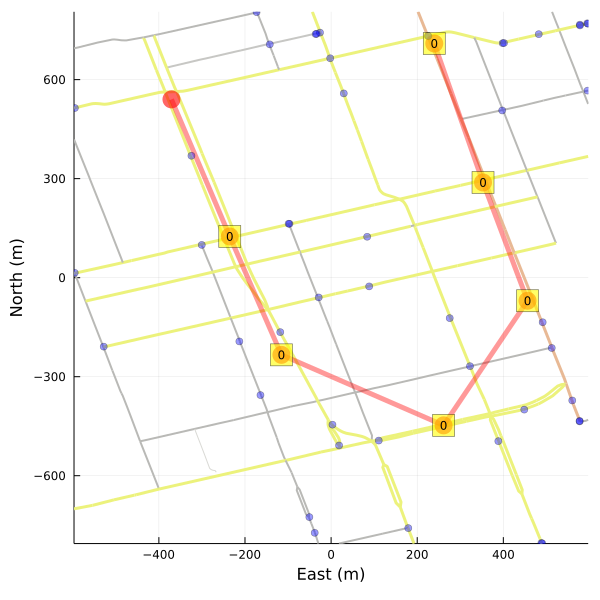

In [110]:
plot_simstate(s, deepcopy(background))

Now we need to define how the agents move around

In [111]:
function step!(model::Simulation, t::EventTime, agent::Agent)
    node2 = agent.pos.node2
    if node2 == length(agent.path)
        agent.pos = OSMXPos(1, 2, 0.0)
    else
        if agent.pos.trav+0.05+eps() < 1
            agent.pos = OSMXPos(agent.pos, 0.05)
        else
            agent.pos = OSMXPos(node2, node2+1, 0.0)
        end
    end
    n1 = agent.path[agent.pos.node1]
    if  n1 >= model.ttc_line[1]
        push!(model.station_q[n1-model.ttc_line[1]+1], agent)
    else
        travel_time =max(0.001, model.m.w[agent.path[agent.pos.node1], agent.path[agent.pos.node2]])/20
        enqueue!(model.events, agent, (t[1]+travel_time,rand()) )
    end
end

# TTC car
function step!(model::Simulation, t::EventTime, wagon::Wagon)
    #wagon moves every qaerter minute
    if wagon.pos.trav+0.125+eps() < 1
        wagon.pos = OSMXPos(wagon.pos, 0.125)
    else
        node2 = wagon.pos.node2
        wagon.pos = OSMXPos(node2, node2 + 1 > nrow(model.ttc) ? 1 : node2 + 1)
        passengers = Agent[]
        for agent in wagon.passengers            
            agent.pos = OSMXPos(agent.pos.node2,agent.pos.node2+1,0.0)
            #check if next pos is still in TTC
            if agent.path[agent.pos.node2] <= nv(model.m.g)-nrow(model.ttc)
                agent.commuting = false
                #drop off
                enqueue!(model.events, agent, EventTime((t[1],rand())))
            else 
                push!(passengers, agent)
            end                        
        end
        for agent in model.station_q[node2]
            if agent.path[agent.pos.node2] == wagon.path[wagon.pos.node2]
                agent.commuting = true 
                push!(passengers, agent)
            end
        end
        filter!(a -> a.path[a.pos.node2] !== wagon.path[wagon.pos.node2],  model.station_q[node2])
        wagon.passengers = passengers
    end    
    enqueue!(model.events, wagon, EventTime((t[1]+0.25,-wagon.id/100.0)))
end

step! (generic function with 2 methods)

This steps the agents as long as at least Wagon no 1 has moved

In [112]:
function step_round!(model)
    ix = 0
    while true && ix <= 1e8
        event, t = dequeue_pair!(model.events)
        step!(model, t, event)
        typeof(event) == Wagon && event.id==1 && break
        ix += 1
    end
    @assert ix < 1e8-1
end

step_round! (generic function with 1 method)

Let us step the simulation few times and see how the agents move around the city

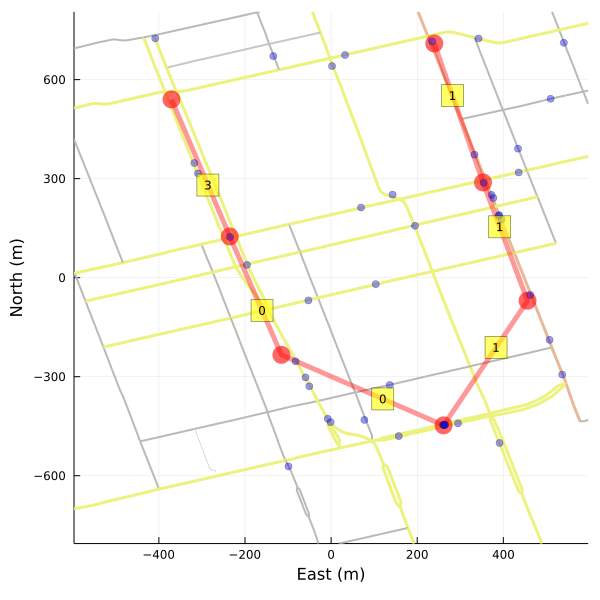

In [113]:
for i in 1:51
    step_round!(s)
end
plot_simstate(s, deepcopy(background))

Now we run the simulation in a larger scale

In [115]:
Random.seed!(0)
s = Simulation(m, ttc; N=5000);


frames = Plots.@animate for i in 1:240
    step_round!(s)
    plot_simstate(s, deepcopy(background))
end

gif(frames, "anim_ttc.gif", fps = 5);

┌ Info: Saved animation to 
│   fn = C:\AAABIBLIOTEKA\JuliaCon2021\demo\anim_ttc.gif
└ @ Plots C:\JuliaPkg\Julia-1.6.1\packages\Plots\YVapH\src\animation.jl:104


Once you have run you will have a local `anim_ttc.gif` file - double click this cell to update the link that points to it
![Animation](https://szufel-public.s3.us-east-2.amazonaws.com/anim_ttc.gif)